In [1]:
%matplotlib inline

import logging

import emcee
import h5py
import numpy as np
import matplotlib.pyplot as plt

from os import path
from glob import glob
import sys
sys.path.insert(0, path.abspath('../'))

from src import workdir, parse_model_parameter_file
from src.emulator import Emulator

In [2]:
model_par = "../model_parameter_dict_examples/IPGlasmaDiffraction.txt"
training_set = "../training_data"
emu = Emulator(training_set, model_par, npc=10)

[INFO][emulator] loading training data from ../training_data ...
[INFO][emulator] All training data are loaded.
[INFO][emulator] 10 PCs explain 0.99999 of variance
[INFO][emulator] Training emulators...
[INFO][emulator] GP 0: 0.89559 of variance, LML = 62.827, kernel: 3.3**2 * RBF(length_scale=[5.36, 65.4, 20.4, 4.39, 19.4, 1.28]) + WhiteKernel(noise_level=0.00324)
[INFO][emulator] GP 1: 0.05621 of variance, LML = -23.29, kernel: 3.04**2 * RBF(length_scale=[2.71, 12.4, 28.1, 4.89, 6.39, 2.18]) + WhiteKernel(noise_level=0.0219)
[INFO][emulator] GP 2: 0.02902 of variance, LML = -52.911, kernel: 2.57**2 * RBF(length_scale=[2.52, 23.7, 6.8, 1.99, 5.05, 1.44]) + WhiteKernel(noise_level=0.0196)
[INFO][emulator] GP 3: 0.01310 of variance, LML = -30.646, kernel: 2.9**2 * RBF(length_scale=[4.93, 22.3, 4.92, 1.59, 14.3, 130]) + WhiteKernel(noise_level=0.0347)
[INFO][emulator] GP 4: 0.00321 of variance, LML = -98.354, kernel: 1.56**2 * RBF(length_scale=[1.47, 6.23, 3.19, 1.65, 10.5, 2.03]) + Whit

/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 130.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified lower bound 0.099. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [3]:
def load_validation_data(data_path):
    """This function read in training data set at every sample point"""
    print("loading training data from {} ...".format(data_path))
    validationData = []
    validationDataErr = []
    validationModelParams = []
    for iev in glob(path.join(data_path, "*")):
        event_id = iev.split("_")[-1]
        with open(path.join(iev, "parameter_{}".format(event_id)), "r") as parfile:
            parameters = []
            for line in parfile:
                line = line.split()
                parameters.append(float(line[1]))
        validationModelParams.append(parameters)
        temp_data = np.loadtxt(path.join(iev, "Bayesian_output.txt"))
        validationData.append(np.log(temp_data[:, 1]))
        validationDataErr.append(temp_data[:, 2]/np.abs(temp_data[:, 1]))
    validationModelParams = np.array(validationModelParams)
    validationData = np.array(validationData)
    validationDataErr = np.nan_to_num(np.array(validationDataErr))
    return(validationModelParams, validationData, validationDataErr)

In [8]:
# Load validation data
validateFolder = path.abspath("../validation_data")

# Load training data
#validateFolder = path.abspath("../training_data") 

validationParams, validationData, validationDataErr = load_validation_data(validateFolder)

loading training data from /Volumes/ChunShen_WDWork/Works_on_going/IPGlasmaDiffraction/bayesian_analysis/validation_data ...


In [9]:
emulatorPredMean, emulatorPredCov = emu.predict(validationParams, return_cov=True)

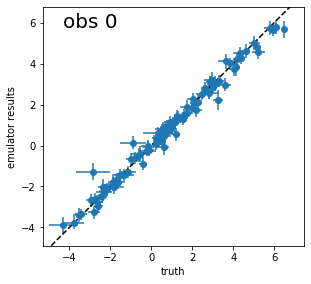

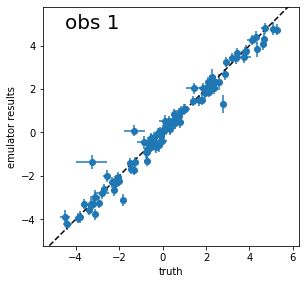

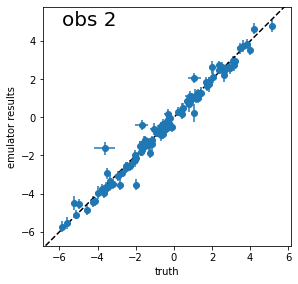

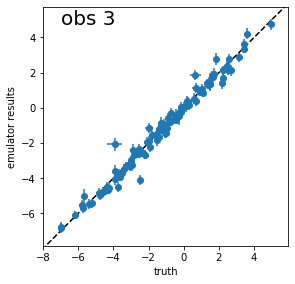

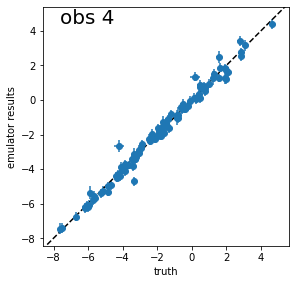

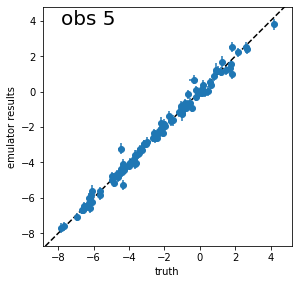

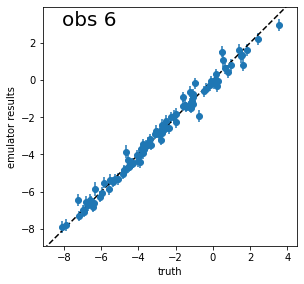

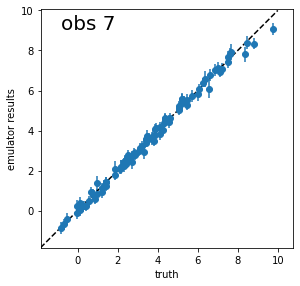

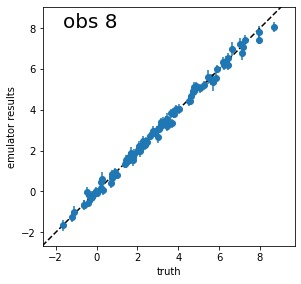

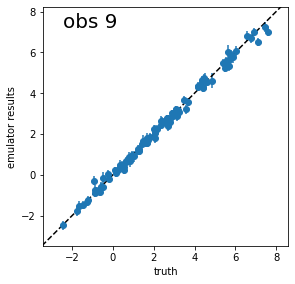

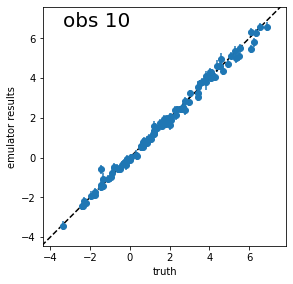

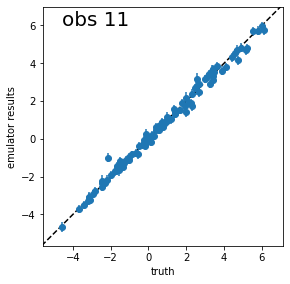

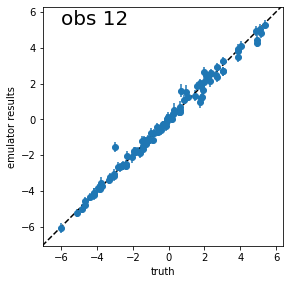

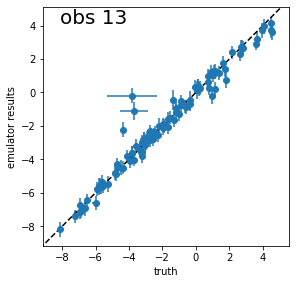

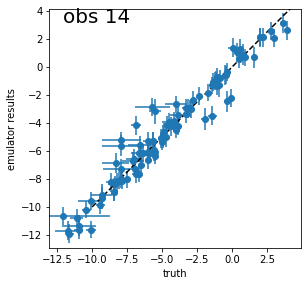

In [10]:
nValidationPoints, nObs = validationData.shape

for obsIdx in range(nObs):
    fig = plt.figure()
    ax = plt.axes([0.12, 0.12, 0.83, 0.83])
    plt.errorbar(validationData[:, obsIdx], emulatorPredMean[:, obsIdx],
                 yerr=np.sqrt(emulatorPredCov[:, obsIdx, obsIdx]),
                 xerr=validationDataErr[:, obsIdx],
                 marker="o", linestyle="")
    plt.plot([-10, 10], [-10, 10], '--k')
    plt.xlim([validationData[:, obsIdx].min() - 1,
              validationData[:, obsIdx].max() + 1])
    plt.ylim([emulatorPredMean[:, obsIdx].min() - 1,
              emulatorPredMean[:, obsIdx].max() + 1])
    ax.set_aspect('equal')
    plt.text(validationData[:, obsIdx].min(),
             emulatorPredMean[:, obsIdx].max(),
             "obs {}".format(obsIdx), fontsize=20)
    plt.xlabel("truth")
    plt.ylabel("emulator results")

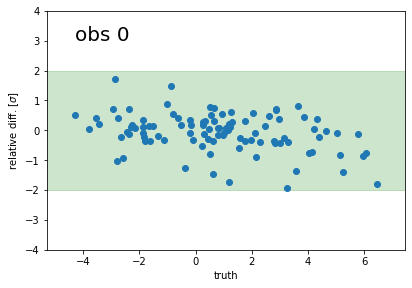

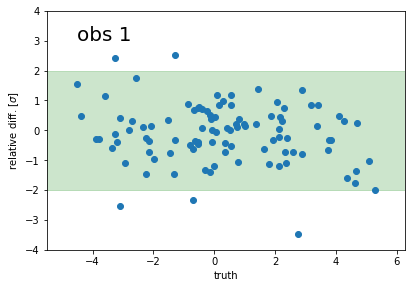

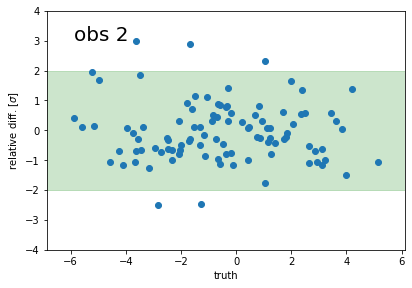

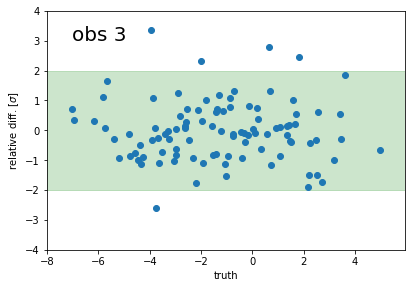

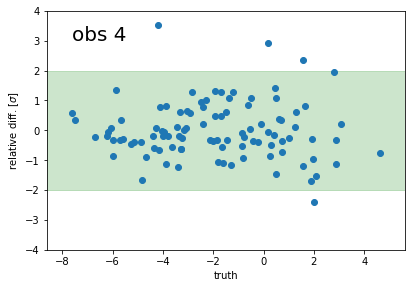

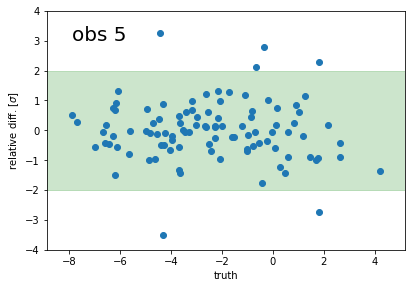

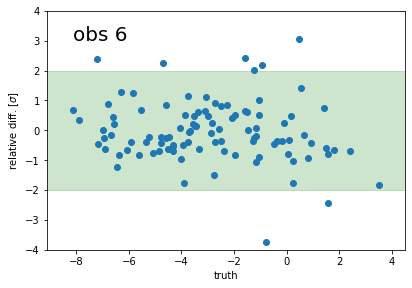

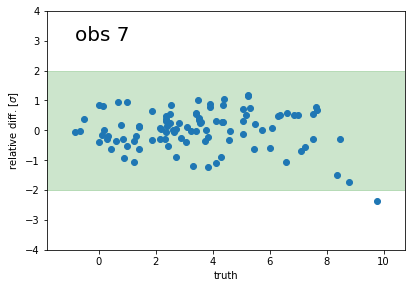

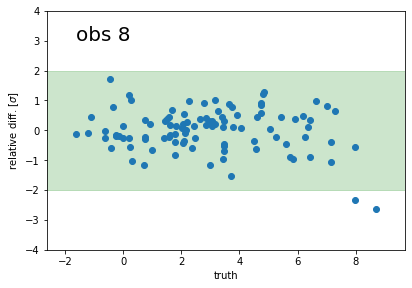

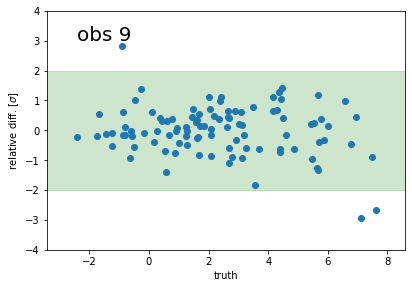

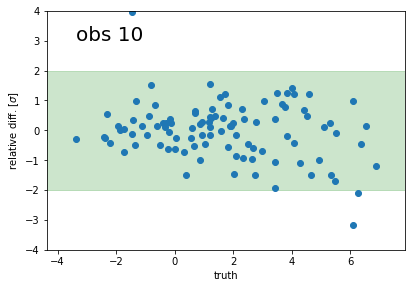

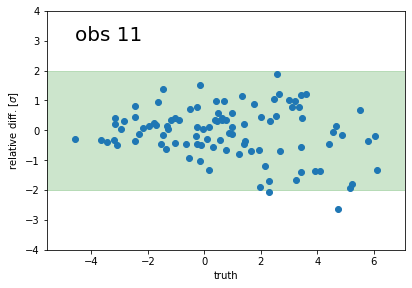

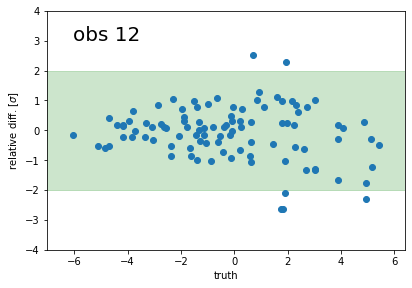

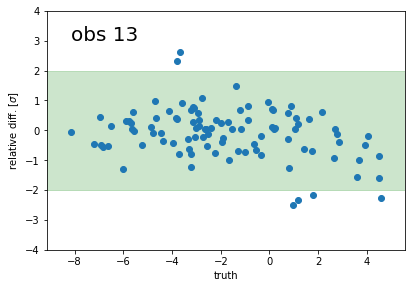

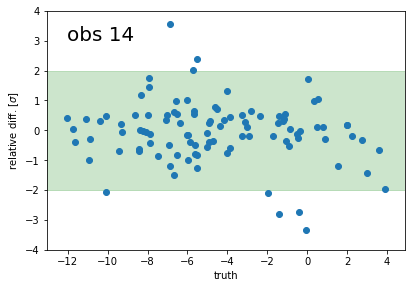

In [11]:
nValidationPoints, nObs = validationData.shape

for obsIdx in range(nObs):
    fig = plt.figure()
    ax = plt.axes([0.12, 0.12, 0.83, 0.83])
    plt.plot(validationData[:, obsIdx],
             (emulatorPredMean[:, obsIdx] - validationData[:, obsIdx])
             /np.sqrt(validationDataErr[:, obsIdx]**2.
                      + emulatorPredCov[:, obsIdx, obsIdx]),
             marker="o", linestyle="")
    plt.fill_between([-20, 20], [2, 2], [-2, -2], color='g', alpha=0.2)
    plt.xlim([validationData[:, obsIdx].min() - 1,
              validationData[:, obsIdx].max() + 1])
    plt.ylim([-4, 4])
    plt.text(validationData[:, obsIdx].min(), 3,
             "obs {}".format(obsIdx), fontsize=20)
    plt.xlabel("truth")
    plt.ylabel("relative diff. [$\sigma$]")